# Modeling

In [2]:
import numpy as np
from bs4 import BeautifulSoup
import requests
from sklearn.linear_model import RidgeCV
import scipy.stats as stats
import statsmodels.api as sm
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import random
import os
import pandas as pd
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import ProbPlot
import seaborn as sns
import pandas as pd
plt.style.use('seaborn')
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

# Train & Validate

### Basic OLS

In [3]:
df = pd.read_pickle("../data/cleaned_df.pkl")

In [4]:
import patsy
y, X = patsy.dmatrices(
    'y_log ~   all_text + project_length + photo_cnt_t + all_sentiment_neg + num_gift_options_t',
    data=df,
    return_type="dataframe")

In [5]:
model = sm.OLS(y, X)

fit = model.fit()

print('RMSE:', np.sqrt(mean_squared_error(y,fit.predict(X))))

fit.summary()

RMSE: 1.881119924930568


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  y_log   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     36.42
Date:                Thu, 24 Jan 2019   Prob (F-statistic):           2.74e-28
Time:                        20:04:53   Log-Likelihood:                -551.67
No. Observations:                 269   AIC:                             1115.
Df Residuals:                     263   BIC:                             1137.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.3439      0.418     12.772      0.000       4.520       6.168
all_text               0.0008      0.000      2.961      0.003       0.000       0.001
project_length        -0.0066      0.008     -0.871      0.385      -0.021       0.008
photo_cnt_t            0.8920      0.149      5.992      0.000       0.599       1.185
all_sentiment_neg     -8.0056      3.467     -2.309      0.022     -14.832      -1.179
num_gift_options_t     0.5427      0.110      4.921      0.000       0.326       0.760
==============================================================================
Omnibus:                        7.285   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                7.131
Skew:                          -0.390   Prob(JB):                       0.0283
Kurtosis:                       3.166   Cond. No.                     2.29e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Training and Validation DataFrame Setup

In [6]:
y = df['y_log']

In [7]:
X = X.loc[:,['all_text','project_length','photo_cnt_t','all_sentiment_neg', 'num_gift_options_t']]

In [8]:
X_orig = X.copy()
y_orig = y.copy()

In [23]:
X = X_orig
y = y_orig

In [24]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=77)

In [11]:
X, y = np.array(X), np.array(y)

In [12]:
def adjusted_r_squared(r_squared, X, y):
    return 1 - (1 - r_squared) * (len(y) - 1) / (len(y) - X.shape[1] - 1)

### Run 3-Fold Ridge CV with 100 Random Splits

In [14]:
# Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

In [15]:
from sklearn.model_selection import KFold
split_means_r2_lm, split_means_r2_lmreg, split_means_r2_hub = [], [], []
split_means_mae_lm, split_means_mae_lm_reg, split_means_mae_hub = [], [], []


for i in range(1, 1001):

    kf = KFold(n_splits=3, shuffle=True, random_state=i)
    cv_lm_r2s, cv_lm_reg_r2s, cv_lm_mae, cv_lm_reg_mae, cv_hub_r2s, cv_hub_mae = [
    ], [], [], [], [], []

    for train_ind, val_ind in kf.split(X, y):

        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind]

        # Define Linear Regression, Ridge and Huber Models
        lm = LinearRegression()
        lm_reg = Ridge(alpha=18.04186)
        huber = HuberRegressor(epsilon=1.35, alpha=14.9926843)

        # Linear Regression Score
        lm.fit(X_train, y_train)
        cv_lm_r2s.append(adjusted_r_squared(
            lm.score(X_val, y_val), X_val, y_val))
        cv_lm_mae.append(mae(y_val, lm.predict(X_val)))

        # Scale Features for Ridge and Lasso use
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        # Ridge Score
        lm_reg.fit(X_train_scaled, y_train)
        cv_lm_reg_r2s.append(adjusted_r_squared(
            lm_reg.score(X_val_scaled, y_val), X_val_scaled, y_val))
        cv_lm_reg_mae.append(mae(y_val, lm_reg.predict(X_val_scaled)))

        # Huber
        huber.fit(X_train_scaled, y_train)
        cv_hub_r2s.append(adjusted_r_squared(
            huber.score(X_val_scaled, y_val), X_val_scaled, y_val))
        cv_hub_mae.append(mae(y_val, huber.predict(X_val_scaled)))
    split_means_r2_lm.append(np.mean(cv_lm_r2s))
    split_means_r2_lmreg.append(np.mean(cv_lm_reg_r2s))
    split_means_r2_hub.append(np.mean(cv_hub_r2s))
    split_means_mae_lm.append(np.mean(cv_lm_mae))
    split_means_mae_lm_reg.append(np.mean(cv_lm_reg_mae))
    split_means_mae_hub.append(np.mean(cv_hub_mae))

In [16]:
print(f'1000 Random Splits - Simple mean cv adj. r^2: {np.mean(split_means_r2_lm):.3f} +- {np.std(split_means_r2_lm):.3f}')
print(f'1000 Random Splits - All Ridge mean cv adj. r^2: {np.mean(split_means_r2_lmreg):.3f} +- {np.std(split_means_r2_lmreg):.3f}')
print(f'1000 Random Splits - All Huber mean cv adj. r^2: {np.mean(split_means_r2_hub):.3f} +- {np.std(split_means_r2_hub):.3f}')

print(f'1000 Random Splits - All Simple mean MAE cv: {np.mean(split_means_mae_lm):.3f} +- {np.std(split_means_mae_lm):.3f}')
print(f'1000 Random Splits - All Ridge mean MAE cv: {np.mean(split_means_mae_lm_reg):.3f} +- {np.std(split_means_mae_lm_reg):.3f}')
print(f'1000 Random Splits - All Huber mean MAE cv: {np.mean(split_means_mae_hub):.3f} +- {np.std(split_means_mae_hub):.3f}')


1000 Random Splits - Simple mean cv adj. r^2: 0.272 +- 0.026
1000 Random Splits - All Ridge mean cv adj. r^2: 0.277 +- 0.024
1000 Random Splits - All Huber mean cv adj. r^2: 0.280 +- 0.022
1000 Random Splits - All Simple mean MAE cv: 1.513 +- 0.024
1000 Random Splits - All Ridge mean MAE cv: 1.512 +- 0.021
1000 Random Splits - All Huber mean MAE cv: 1.503 +- 0.021


### Find Best Alpha for Huber Regression

In [6397]:
# For this section, re-generate original dataframes before running
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20,random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [6398]:
alphalist = 10**(np.linspace(-2, 2, 200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i, curr_alpha in enumerate(alphalist):

    steps = [('standardize', StandardScaler()),
             ('huber', HuberRegressor(epsilon=1.35, alpha=curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(
        X_train.loc[:, [
            'all_text','project_length','photo_cnt_t','all_sentiment_neg', 'num_gift_options_t'
        ]].values, y_train)

    val_set_pred = pipe.predict(X_val.loc[:, [
        'all_text','project_length','photo_cnt_t','all_sentiment_neg', 'num_gift_options_t'
    ]].values)
    err_vec_val[i] = mae(y_val, val_set_pred)
alphalist[np.argmin(err_vec_val)]

14.992684327860456

### Find Best Lambda for Ridge CV

In [6246]:
# For this section, re-generate original dataframes before running
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20,random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [6400]:
alphalist = 10**(np.linspace(-2, 2, 200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i, curr_alpha in enumerate(alphalist):

    steps = [('standardize', StandardScaler()),
             ('ridge', Ridge(alpha=curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(
        X_train.loc[:, [
            'all_text','project_length','photo_cnt_t','all_sentiment_neg', 'num_gift_options_t'
        ]].values, y_train)

    val_set_pred = pipe.predict(X_val.loc[:, [
        'all_text','project_length','photo_cnt_t','all_sentiment_neg', 'num_gift_options_t'
    ]].values)
    err_vec_val[i] = mae(y_val, val_set_pred)
alphalist[np.argmin(err_vec_val)]

18.04186409392072

# 80/20 Train Test Split
Using the split defined pre-validation above.

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

huber = HuberRegressor(epsilon=1.35, alpha=14.9926843)
huber.fit(X_scaled, y)

print(adjusted_r_squared(huber.score(X_test_scaled, y_test), X_test_scaled, y_test))

test_set_pred = huber.predict(X_test_scaled)

print(mae(y_test, test_set_pred))

0.38868149396247953
1.6101265873227788


# Interpretation
a unit increase in x is associated with an increase of 100(e^β − 1) percent in y

In [18]:
huber.coef_

array([ 0.42487367, -0.11582127,  0.84860936, -0.25996233,  0.47267935])

In [19]:
# Every additional unit increase in Length leads to -10.9% decrease in pledged
100*(np.exp(huber.coef_[1]) - 1)

-10.936560999728751

In [20]:
# Every additional unit increase in Negative Sentiment Score leads to -22% decrease in pledged
100*(np.exp(huber.coef_[3]) - 1)

-22.89193705059185

# OLS Assumptions

### Diagnostic Plot Code taken from: https://robert-alvarez.github.io/

In [21]:
def graph(formula, x_range, label=None):
    """
    Helper function for plotting cook's distance lines
    """
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')


def diagnostic_plots(X, y, model_fit=None):
    """
    Function to reproduce the 4 base plots of an OLS model from R.

    ---
    Inputs:

    X: A numpy array or pandas dataframe of the features to use in building the linear regression model

    y: A numpy array or pandas series/dataframe of the target variable of the linear regression model

    model_fit [optional]: a statsmodel.api.OLS model after regressing y on X. If not provided, will be
                          generated from X, y
    """

    if not model_fit:
        model_fit = sm.OLS(y, sm.add_constant(X)).fit()

    # create dataframe from X, y for easier plot handling
    dataframe = pd.concat([X, y], axis=1)

    # model values
    model_fitted_y = model_fit.fittedvalues
    # model residuals
    model_residuals = model_fit.resid
    # normalized residuals
    model_norm_residuals = model_fit.get_influence().resid_studentized_internal
    # absolute squared normalized residuals
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    # absolute residuals
    model_abs_resid = np.abs(model_residuals)
    # leverage, from statsmodels internals
    model_leverage = model_fit.get_influence().hat_matrix_diag
    # cook's distance, from statsmodels internals
    model_cooks = model_fit.get_influence().cooks_distance[0]

    # Residuals vs Fitted Plot
    plot_lm_1 = plt.figure()
    plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                                      lowess=True,
                                      scatter_kws={'alpha': 0.5},
                                      line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

    plot_lm_1.axes[0].set_title('Residuals vs Fitted')
    plot_lm_1.axes[0].set_xlabel('Fitted values')
    plot_lm_1.axes[0].set_ylabel('Residuals')

    # Normal Q-Q Plot
    QQ = ProbPlot(model_norm_residuals)
    plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
    plot_lm_2.axes[0].set_title('Normal Q-Q')
    plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
    plot_lm_2.axes[0].set_ylabel('Standardized Residuals')
    # annotations
    abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    for r, i in enumerate(abs_norm_resid_top_3):
        plot_lm_2.axes[0].annotate(i,
                                   xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                       model_norm_residuals[i]))

    # Scale vs Location Plot
    plot_lm_3 = plt.figure()
    plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
    sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
                scatter=False,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plot_lm_3.axes[0].set_title('Scale-Location')
    plot_lm_3.axes[0].set_xlabel('Fitted values')
    plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$')

    # annotations
    abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
    abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
    for i in abs_norm_resid_top_3:
        plot_lm_3.axes[0].annotate(i,
                                   xy=(model_fitted_y[i],
                                       model_norm_residuals_abs_sqrt[i]))

    # Residuals vs Leverage Plot
    plot_lm_4 = plt.figure()
    plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
    sns.regplot(model_leverage, model_norm_residuals,
                scatter=False,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
    plot_lm_4.axes[0].set_ylim(-3, 5)
    plot_lm_4.axes[0].set_title('Residuals vs Leverage')
    plot_lm_4.axes[0].set_xlabel('Leverage')
    plot_lm_4.axes[0].set_ylabel('Standardized Residuals')

    # annotations
    leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
    for i in leverage_top_3:
        plot_lm_4.axes[0].annotate(i,
                                   xy=(model_leverage[i],
                                       model_norm_residuals[i]))

    p = len(model_fit.params)  # number of model parameters
    graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
          np.linspace(0.001, max(model_leverage), 50),
          'Cook\'s distance')  # 0.5 line
    graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
          np.linspace(0.001, max(model_leverage), 50))  # 1 line
    plot_lm_4.legend(loc='upper right')

### Plots for non-transformed Variables
i.e. in this run, there is no transformation on the dependent 'pledged', and no transformation on 'photo count', 'negative description sentiment', and 'number of gift options'.

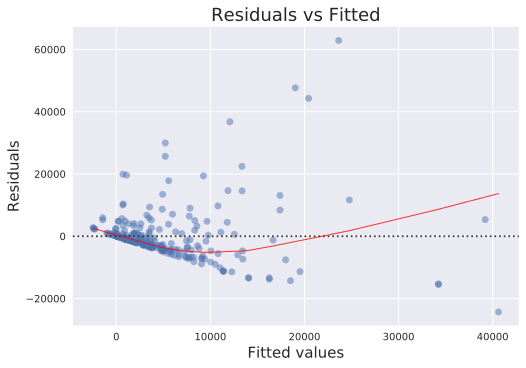

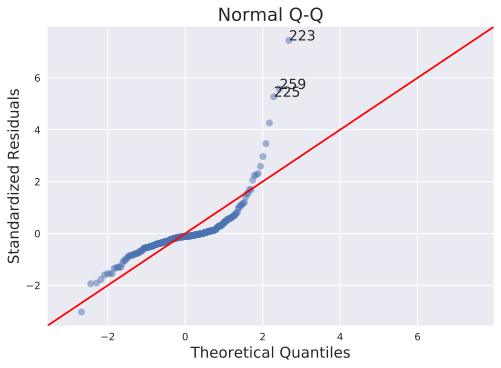

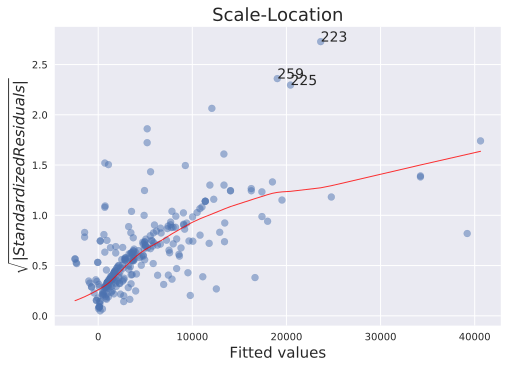

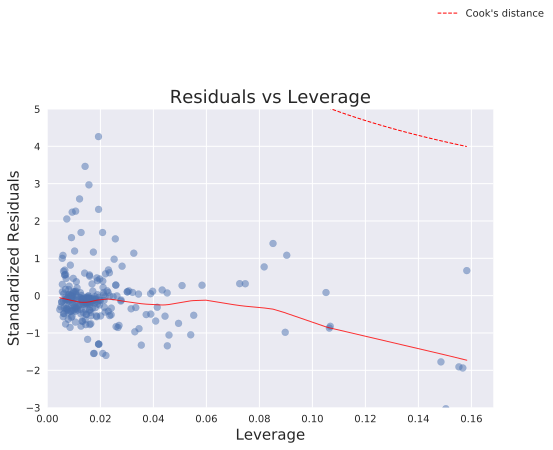

In [6289]:
diagnostic_plots(X, y)

### Plots for Transformed Variables
i.e. in this run, there are transformations on the dependent 'pledged', and transformations on 'photo count', 'negative description sentiment', and 'number of gift options'.

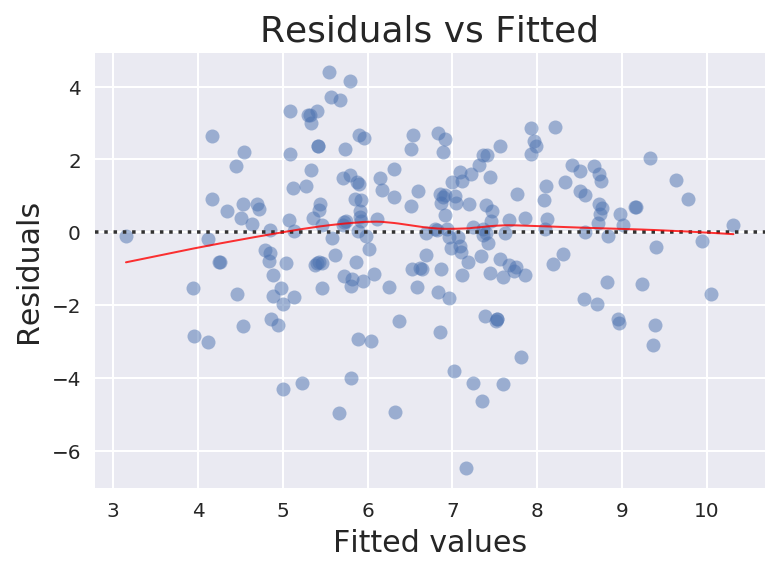

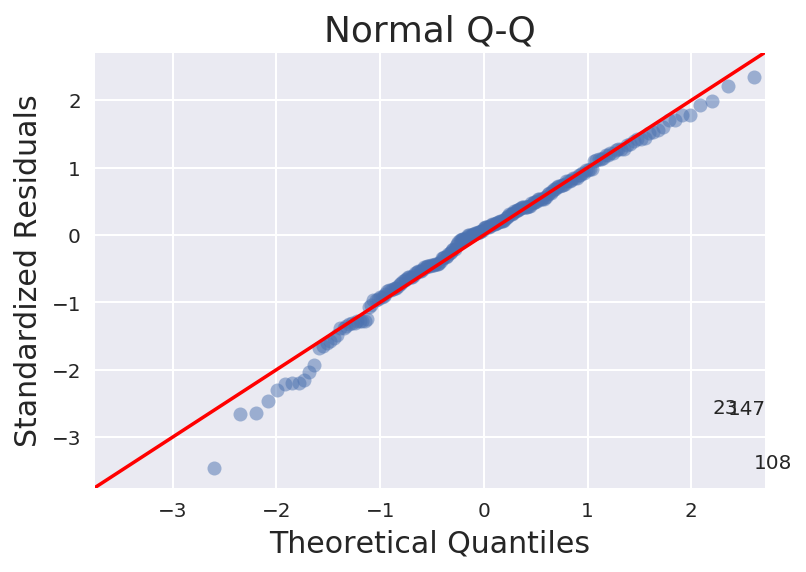

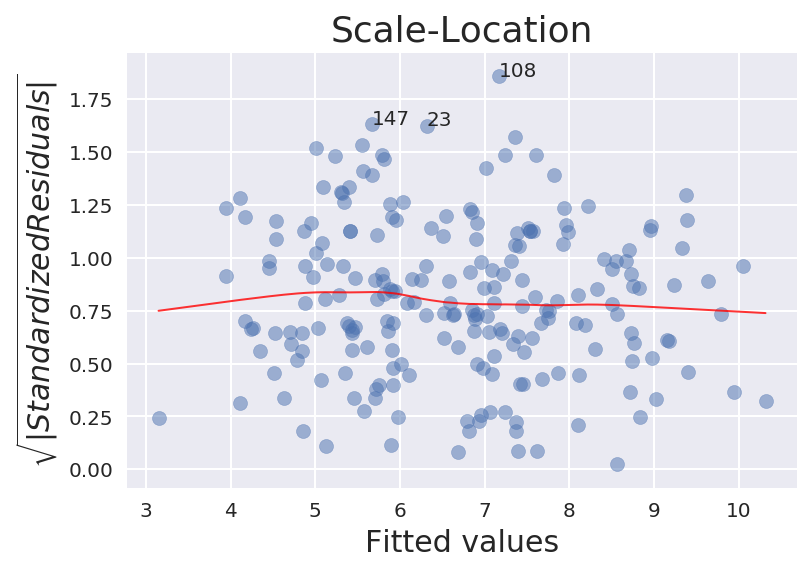

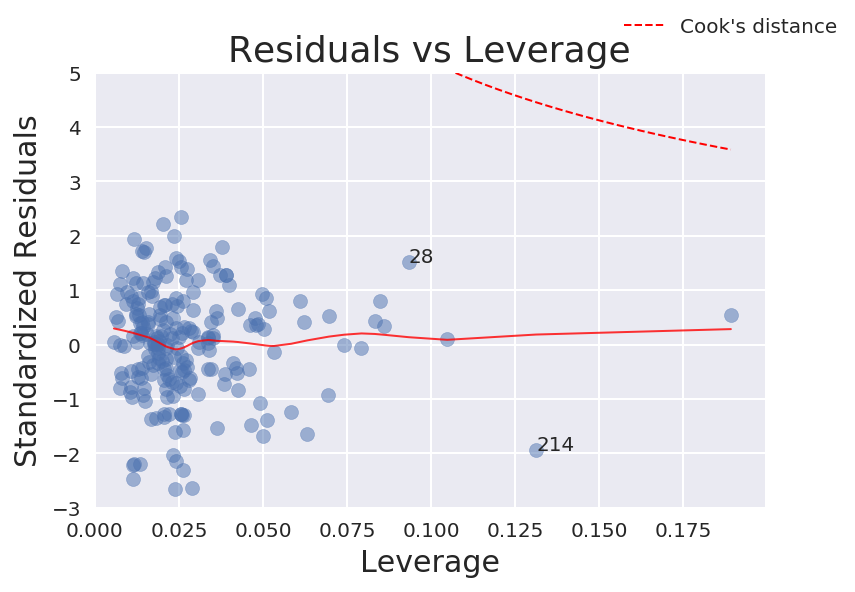

In [25]:
diagnostic_plots(X,y)

# Multicollinearity Check with VIF
No alarming values of VIF for these choices. All under or near the conservative 'rule of thumb' of VIF=4, and many people even use VIF=10 for a threshold.

In [5737]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [6238]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [6239]:
vif.round(1)

,VIF Factor,features
0,2.9,all_text
1,4.3,project_length
2,1.5,photo_cnt_t
3,1.7,all_sentiment_neg
4,4.3,num_gift_options_t
